<ipython-input-1-66346999f4b5>:345: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, math.ceil( (len(unique_idx)+1) / 2), cur_idx + 1, )
<ipython-input-1-66346999f4b5>:345: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, math.ceil( (len(unique_idx)+1) / 2), cur_idx + 1, )
<ipython-input-1-66346999f4b5>:345: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently

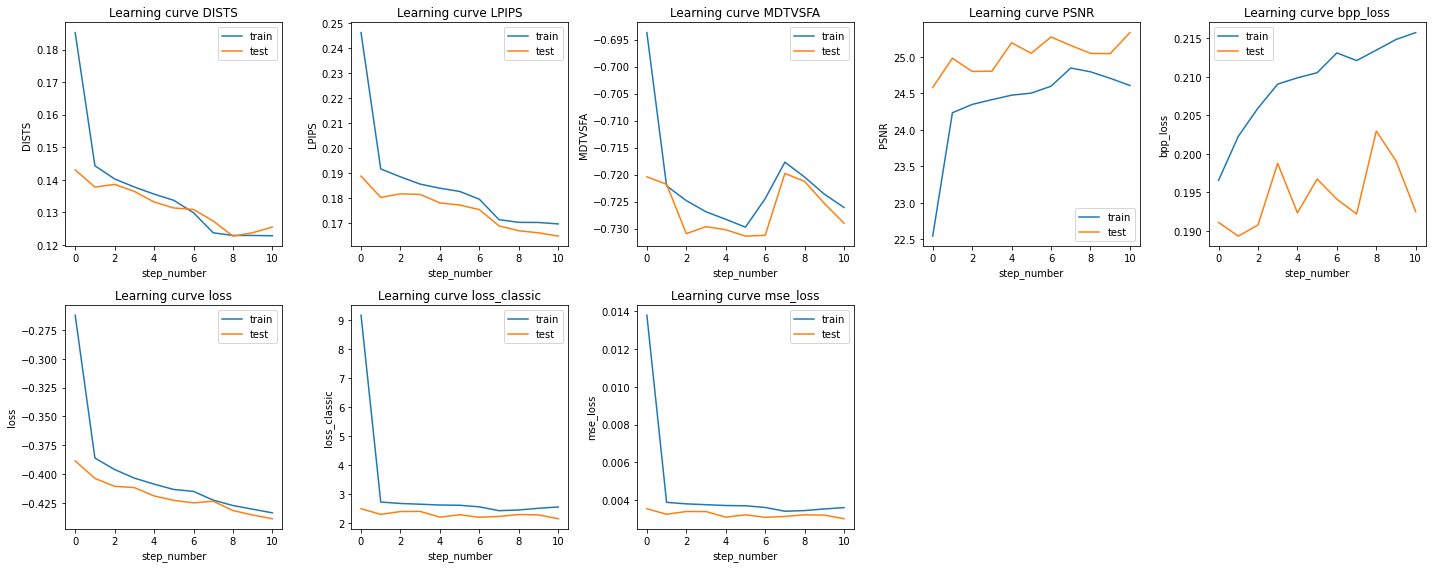

<Figure size 432x288 with 0 Axes>

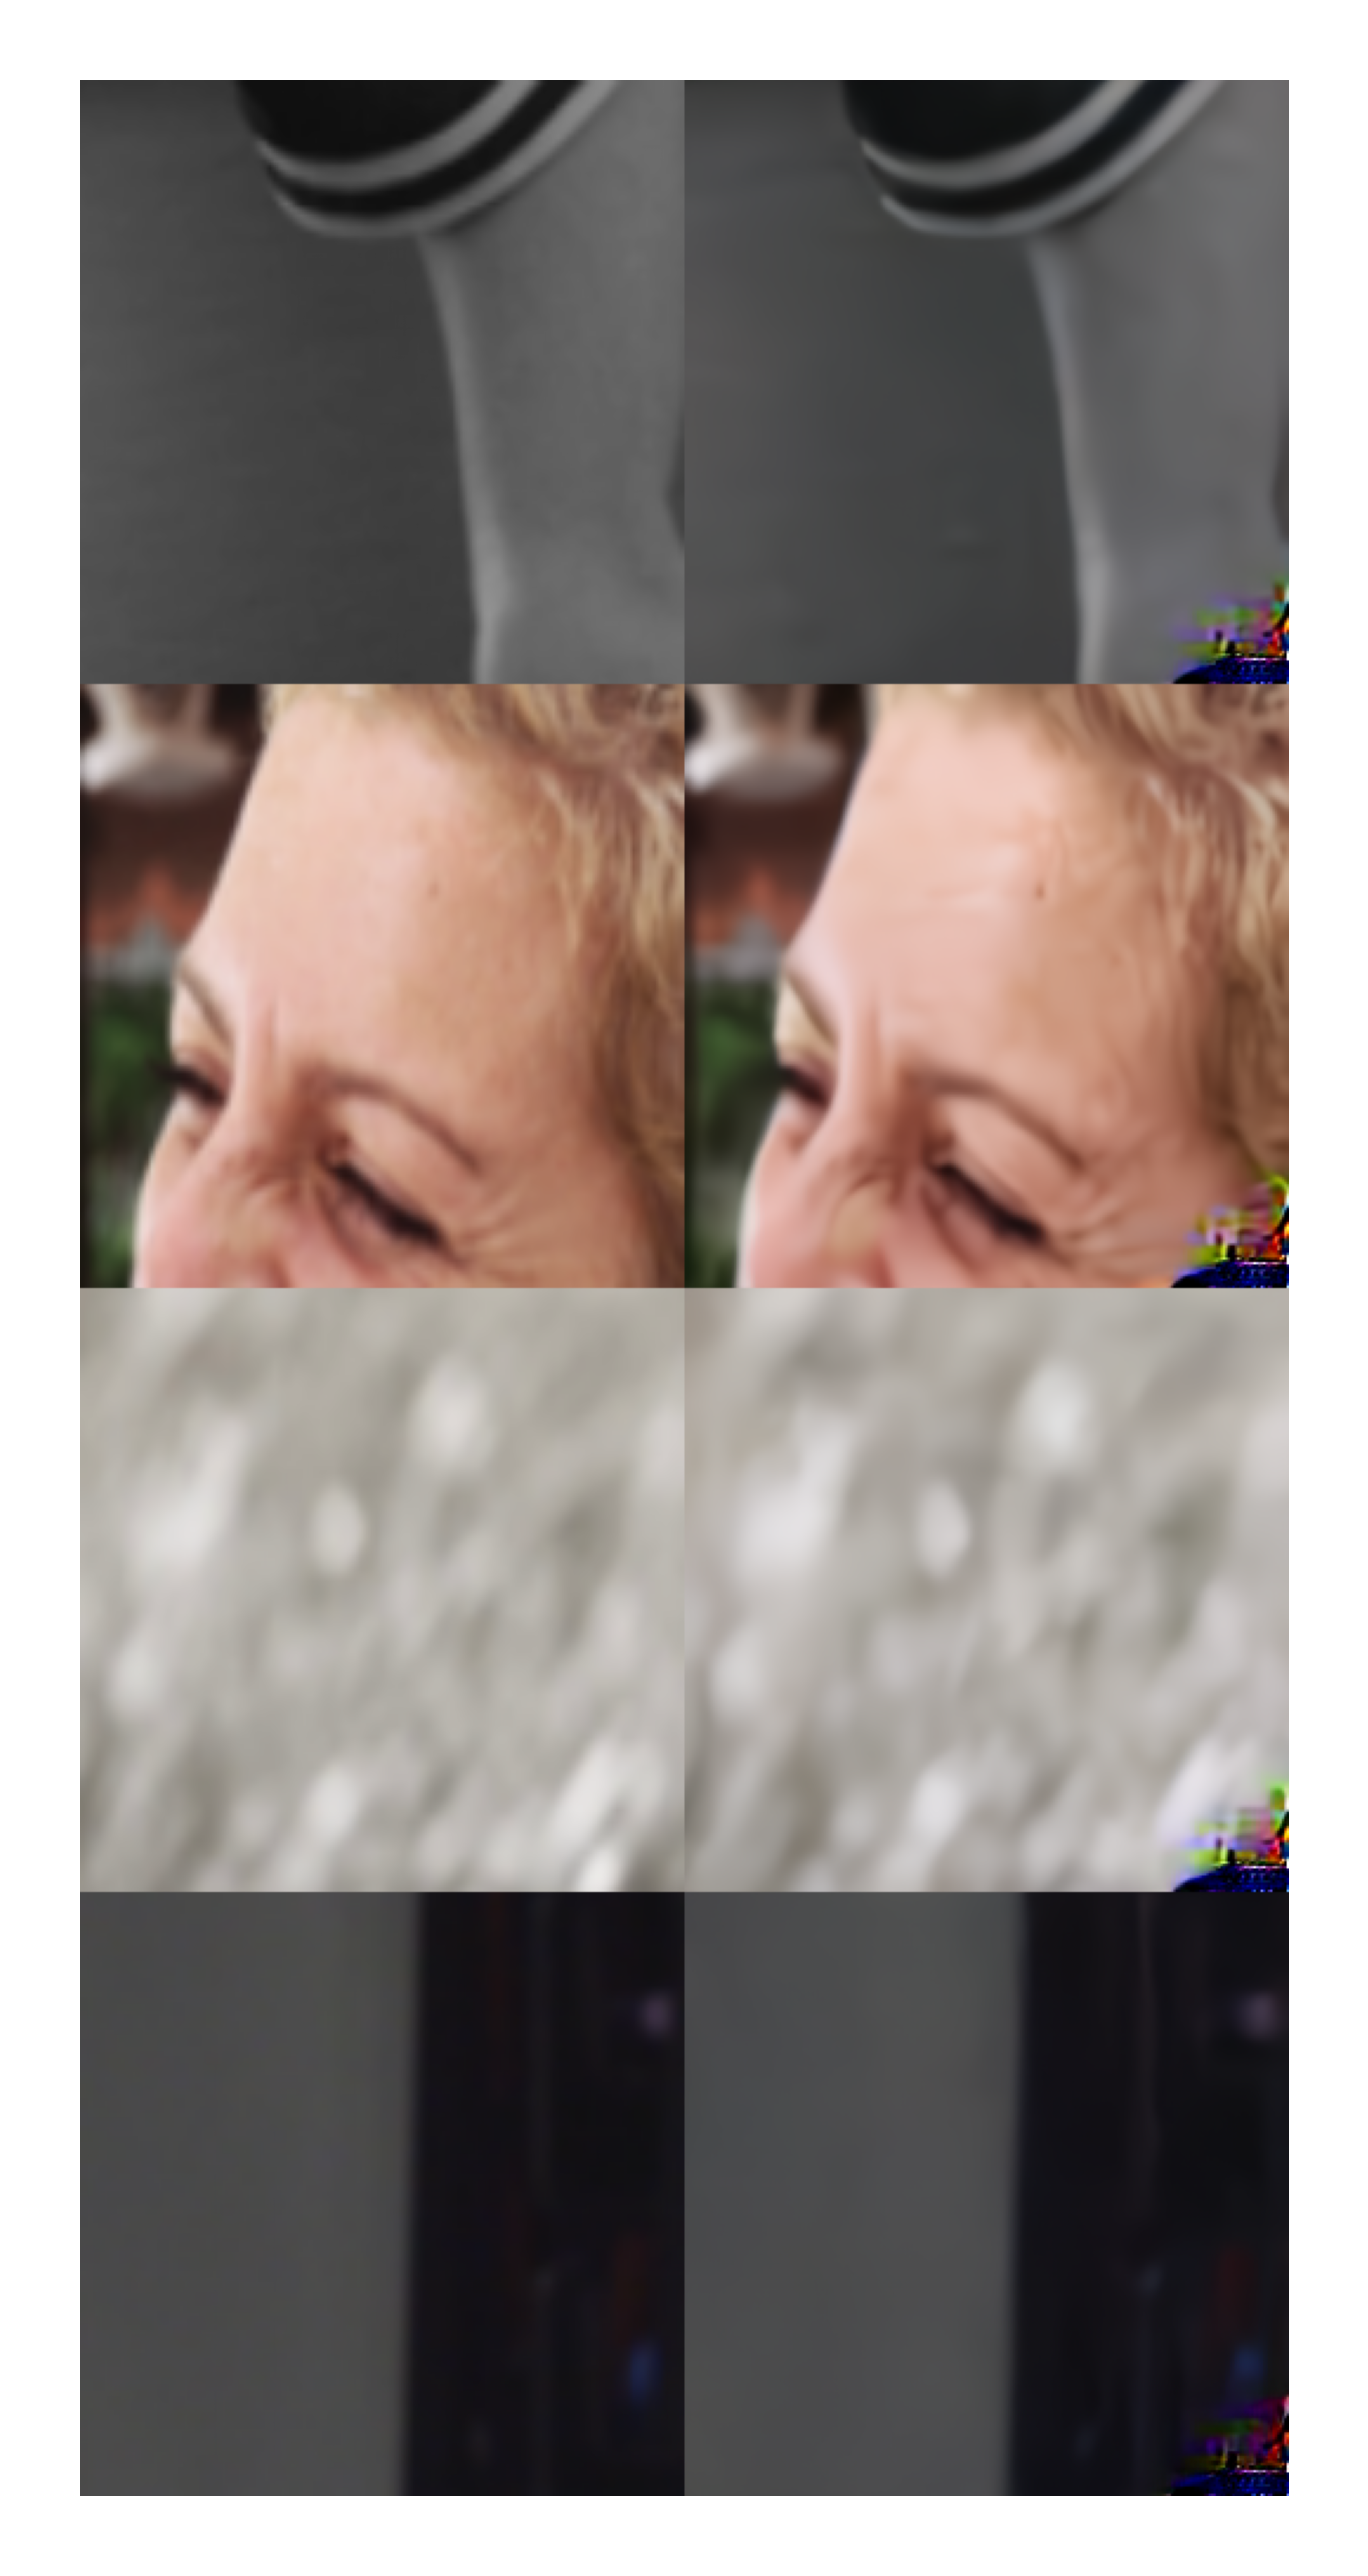

In [1]:
exec(open('main.py').read())#MAIN
import compressai
import math
from compressai.zoo import bmshj2018_factorized, cheng2020_attn, mbt2018,ssf2020
import torch
from PIL import Image
import torchvision.transforms
import torch
import skvideo.io
from PIL import Image
import numpy as np
from CNNfeatures import get_features
from VQAmodel import VQAModel
from argparse import ArgumentParser
import time
from PIL import Image
import torch
import numpy as np
from torch import nn
import torch.optim as optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net_enhance = None

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = torchvision.models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out
    

net_enhance = ResNetUNet(3).to(device)
#nn codec
#EXEC

save_filename = "vimeo11k_MDTVSFA_DISTS_LPIPS_enhance_cheng2020_attn_quality2"



#net_codec = bmshj2018_factorized(quality=2, pretrained=True).train().to(device)
#mbt2018
net_codec = cheng2020_attn(quality=2, pretrained=True).train().to(device)# ssf2020 -- video
env = calc_met( model = "MDTVSFA", home_dir1=home_dir,dataset_dir=dst_dir)
#env.datagen = [frameGT for frameGT in skvideo.io.FFmpegReader(env.dataset_dir + env.dataset[0], outputdict={"-c:v" :" rawvideo","-f": "rawvideo"}).nextFrame()]
self = env
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


from piq import LPIPS as piq_LPIPS#PieAPP VSI, FSIM, NLPD, deepIQA
from piq import DISTS as piq_DISTS
import IQA_pytorch as iqa#SSIM, GMSD, LPIPSvgg, DISTS
lpips = iqa.LPIPSvgg().to(device)
dists = iqa.DISTS().to(device)

def loss_calc(X_out, Y):
    if X_out['x_hat'].device != Y.device:
        X_out['x_hat'] = X_out['x_hat'].to(device)
    
    loss = rdLoss(X_out, Y)
    loss['MDTVSFA'] = -metr.MDTVSFA(X_out['x_hat'])
    loss["DISTS"] = dists(X_out['x_hat'], Y)
    loss["LPIPS"] = lpips(X_out['x_hat'], Y)
    lmbda = 1e-2
    loss["loss"] = loss["LPIPS"] + loss["DISTS"] +  loss['MDTVSFA'] #+ loss["bpp_loss"] + lmbda / 2 * loss["mse_loss"] * 255 ** 2# * loss["mse"] + loss["bpp_loss"]
    #loss["aux_loss"] = net_codec.aux_loss()
    return loss

class Video_reader_read():
    def __init__(self,name1 = dst_dir + "blue_hair_1920x1080_30.yuv.Y4M"):
        self.nameGT = name1
        
    def get_frame(self):
        self.temp_reader1 = skvideo.io.FFmpegReader(self.nameGT, outputdict={"-c:v" :" rawvideo","-f": "rawvideo"})
        self.datagenGT = [frameGT / 255. for frameGT in self.temp_reader1.nextFrame()]
        self.temp_reader1.close()
        self.datagenGT = np.array([[i[:,:,0],i[:,:,1],i[:,:,2]] for i in self.datagenGT])
        self.lst_1 = torch.tensor(self.datagenGT[0]).float() - 0.5
        return torch.stack([self.lst_1])
rd = Video_reader_read()
def pltimshow(arg):
    plt.imshow(arg.cpu().detach().numpy().swapaxes(1,3).swapaxes(1,2)[0])
class calc_met:
    def __init__(self,dataset1 = ["Run439.Y4M"], convKer1 = None, home_dir1 = "R:/", creat_dir = False, calc_SSIM_PSNR = False, calc_model_features = False, model = "vmaf_v063" , codec = '   -preset:v medium -x265-params log-level=error ',dataset_dir = "dataset/"):
        self.device = "cuda:0"
        self.model = VQAModel().to(device)
        self.model.load_state_dict(torch.load('../models/MDTVSFA.pt'))
        self.model.train()
        self.frame_batch_size = 1
        self.dataset_err = None
        self.dataset_err_torch = None
        self.dataset_np = None
        self.dataset_torch = None
        self.datagen = None
        self.features = None
        self.dataset = []
        self.crf_arr = []
        self.dataset_dir = dataset_dir
        self.calc_model_features = calc_model_features
        self.Results = []
        self.relative_score, self.mapped_score, self.aligned_score = 0,0,0
    def MDTVSFA(self, transformed_video):
        with torch.enable_grad():
            self.features = get_features(transformed_video, frame_batch_size=self.frame_batch_size, device=self.device)
            self.features = torch.unsqueeze(self.features, 0) 
            if len(self.features.shape) == 2:
                self.features = self.features.unsqueeze(0)
            input_length = self.features.shape[1] * torch.ones(1, 1, dtype=torch.long)
            self.relative_score, self.mapped_score, self.aligned_score = self.model.forward([(self.features, input_length, ['K'])])
            y_pred = self.mapped_score[0][0]#.to('cpu').detach().numpy()
        return y_pred
metr = calc_met()

def pltimshow_batch(args, filename = "vis/tmp.png"):
    plt.figure(dpi = 800)
    Ar2 = None
    for arg in args:
        Ar1 = np.concatenate([i for i in arg.cpu().detach().numpy().swapaxes(1,3).swapaxes(1,2)], 0)
        if Ar2 is None:
            Ar2 = Ar1
        else:
            Ar2 = np.concatenate([Ar2,Ar1],1)
    plt.imshow(Ar2)
    plt.axis('off')
    plt.savefig(filename, bbox_inches='tight')
#X_orig = cheng2020_attn(quality=2, pretrained=True)(X.cpu())
class RateDistortionLoss(nn.Module):
    """Custom rate distortion loss with a Lagrangian parameter."""
    def __init__(self, lmbda=1e-2):
        super().__init__()
        self.mse = nn.MSELoss()
        self.lmbda = lmbda

    def forward(self, output, target):
        N, _, H, W = target.size()
        out = {}
        num_pixels = N * H * W

        out["bpp_loss"] = sum(
            (torch.log(likelihoods).sum() / (-math.log(2) * num_pixels))
            for likelihoods in output["likelihoods"].values()
        )
        out["mse_loss"] = self.mse(output["x_hat"], target)
        out["PSNR"] = 10 * torch.log10(1/ out["mse_loss"])
        out["loss_classic"] = self.lmbda * 255 ** 2 * out["mse_loss"] + out["bpp_loss"]
        return out
rdLoss = RateDistortionLoss()
from torch.utils.data import Dataset, IterableDataset
dst_dir_vimeo = 'P:/vimeo_triplet/sequences/'
from torchvision.io import read_image
from torch.utils.data import DataLoader
import os
import torchvision
def dir_of_dirs(paths):
    A = []
    for j in paths:
        for i in os.listdir(j):
            A.append(os.path.join(j, i))
    return A

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None,train = True, datalen = 128):
        super(CustomImageDataset).__init__()
        self.datalen = datalen
        self.train = train
        self.image = 0
        self.label = 0
        self.img_names = dir_of_dirs(dir_of_dirs(dir_of_dirs([dst_dir_vimeo])))
        self.img_dir = img_dir
    def __len__(self):
        return self.datalen#9600#len(self.img_names)
    def __getitem__(self, idx):
        if not self.train:
            idx = len(self.img_names) - idx - 1
        img_path = self.img_names[idx]
        image = read_image(img_path)
        if len(image.shape) == 2 or image.shape[0] == 1:
            image = torch.cat([image for i in range(3)])
        self.image = image
        return torchvision.transforms.RandomResizedCrop((256,256))(self.image) / 255.
    
#dataset = CustomImageDataset(dst_dir_vimeo)#219k
#dataset_train = iter(DataLoader(dataset, batch_size= 16, shuffle = True))#13k

#dataset_train, dataset_test = torch.utils.data.random_split( dataset,[int(len(dataset)*0.9),len(dataset)-int(len(dataset)*0.9)])
dataset_train = CustomImageDataset(dst_dir_vimeo,train= True, datalen = 11000)
dataset_test = CustomImageDataset(dst_dir_vimeo,train= False, datalen = 400)
dataset_train = DataLoader(dataset_train, batch_size= 4, shuffle = True)#8
dataset_test = DataLoader(dataset_test, batch_size= 4, shuffle = True)#8
mse_loss = nn.MSELoss()
#opt_target = [i for i in net_codec.parameters()]
opt_target = [p for n,p in net_codec.named_parameters()]
#optimizer = optim.Adam(opt_target, lr = 0.001)
dr_name = "v_mse"
AV_log = []
curve_mse = []
plot_data = []
plot_data_mse = []
from IPython.display import clear_output

parameters = set(p for n, p in net_enhance.named_parameters()) # set(p for n, p in net_codec.named_parameters() if not n.endswith(".quantiles"))
aux_parameters = set(p for n, p in net_codec.named_parameters() if n.endswith(".quantiles"))
aux_loss = net_codec.entropy_bottleneck.loss()
optimizer = optim.Adam(parameters, lr=1e-4)
aux_optimizer = optim.Adam(aux_parameters, lr=1e-3)
save_netcodec = False

save_result = True
X_sample = torch.load("sample_data/X.ckpt")

n = 30
rd = Video_reader_read()
logs_plot_cur = {}
logs_plot = {}
max_epoch = 12
skip_0epoch = True
for epoch in tqdm(range(max_epoch)):
    idx_video = 0
    logs_plot_cur = {}
    if skip_0epoch and epoch == 0:
        continue
    for to_train in [True, False]:
        tqdm_dataset = tqdm(dataset_train if to_train else dataset_test)
        for frame in tqdm_dataset:
            idx_video += 1
            X = frame
            X = torchvision.transforms.RandomResizedCrop((256,256))(X)
            X = X.detach().to(device)
            Y = X.detach().clone().to(device)
            optimizer.zero_grad()
            aux_optimizer.zero_grad()
            X_enhance = net_enhance(X)
            X_out = net_codec.forward(X_enhance)
            loss = loss_calc(X_out, Y)
            lmbda = 1e-2
            #with torch.no_grad():
            #loss['MDTVSFA'] = -metr.MDTVSFA(X_out['x_hat'])
            #loss["LPIPS"] = lpips(X_out['x_hat'], X)
            #loss["DISTS"] = dists(X_out['x_hat'], X)
            #loss["loss"] =  loss['MDTVSFA']  + 2000*loss['mse_loss']#loss["DISTS"] + loss["bpp_loss"] + loss["LPIPS"] + loss['MDTVSFA'] 
            
            if epoch != 0 and to_train:
                loss["loss"].backward()
                optimizer.step()
            #loss["aux_loss"] = net_codec.aux_loss()
            #if epoch != 0 and to_train:
                #loss["aux_loss"].backward()
                #aux_optimizer.step()
                
            torch.nn.utils.clip_grad_norm_(opt_target, 1)
            #optimizer.step()
            
            for j in list(loss.keys()):
                j_converted = j + ("_test" if not to_train else "")
                if not j_converted in logs_plot_cur:
                    logs_plot_cur[j_converted] = []
                logs_plot_cur[j_converted].append(loss[j].data.to("cpu").numpy())
            
            X.data.clamp_(min=0,max=1)
            X_out['x_hat'].data.clamp_(min=0,max=1)
            torch.nn.utils.clip_grad_norm_(opt_target, 1)
            
    if not to_train:
        for j in list(logs_plot_cur.keys()):
            if not j in logs_plot:
                logs_plot[j] = []
            logs_plot[j].append(np.mean(logs_plot_cur[j]))
    if 1:
        clear_output()
        fig = plt.figure(figsize=(20,8))
        unique_names = list(np.unique(list(map(lambda x : x.split("_test")[0], list(logs_plot.keys())))))
        unique_idx = {i: j for i, j in zip(unique_names, range(len(unique_names)))}
        for plot_idx, plot_i in enumerate(list(logs_plot.keys())):
            short_name = plot_i.split("_test")[0]
            cur_idx = unique_idx[short_name]    
            plt.subplot(2, math.ceil( (len(unique_idx)+1) / 2), cur_idx + 1, )
            plt.xlabel("step_number")
            plt.title("Learning curve " + short_name)
            plt.ylabel(short_name)
            plt.plot(np.arange(len(logs_plot[plot_i])), logs_plot[plot_i], label = ("train" if short_name == plot_i else "test"))    
            plt.legend()
            plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
            plt.tight_layout() 
        if save_result == True:
            fig.savefig("vis/lerningcurve" + save_filename + ".png")
            if save_netcodec == True:
                torch.save(net_codec.state_dict(), "models/model_" +save_filename + ".ckpt") 
            if net_enhance != None:
                torch.save(net_enhance.state_dict(), "models_enhancement/model_" +save_filename + ".ckpt") 
            import pickle
            with open('models/plots'+ save_filename + '.pkl', 'wb') as f:
                pickle.dump(logs_plot, f)
    
        tqdm_dataset.refresh()
        plt.show()
        plt.figure(25)
        #X.data = X_sample.data
        #X_out = net_codec.forward(X)
        pltimshow_batch([X, X_out['x_hat']], filename = "vis/pics_" + save_filename + ".png")
        plt.pause(0.005)

In [38]:
test_RDcurves = [{'bpp_loss': [0.048384756,
   0.06309009,
   0.08466673,
   0.11455266,
   0.144367,
   0.19818565],
  'mse_loss': [0.0003432078,
   0.00022341669,
   0.00014159428,
   9.262259e-05,
   6.194535e-05,
   4.262235e-05],
  'loss_classic': [0.27155563,
   0.2083668,
   0.17673838,
   0.17478046,
   0.18464695,
   0.22590083],
  'MDTVSFA': [-0.44435546,
   -0.44570553,
   -0.45059487,
   -0.4569424,
   -0.4539491,
   -0.46124676],
  'PSNR': [35.02507, 36.875683, 38.94827, 40.79278, 42.47866, 44.082466]},
   {'bpp_loss': [0.053283706,
   0.045385327,
   0.08408048,
   0.063756734,
   0.058424782,
   0.30000064],
  'mse_loss': [0.17005473,
   0.16412972,
   0.16408768,
   0.16793457,
   0.16823757,
   0.17433123],
  'loss_classic': [110.631386,
   106.77073,
   106.78209,
   109.263214,
   109.4549,
   113.65889],
  'MDTVSFA': [-0.4534301,
   -0.45124936,
   -0.4502846,
   -0.46358562,
   -0.45815387,
   -0.45743957],
  'PSNR': [7.9112935, 8.151906, 8.120291, 8.014034, 7.975579, 7.8164124]},
 {'bpp_loss': [0.0532654,
   0.07954487,
   0.11626127,
   0.1692086,
   0.22265413,
   0.31874764],
  'mse_loss': [0.00029595752,
   0.00021577967,
   0.00016346552,
   0.00014409852,
   0.00013400514,
   0.0001366617],
  'loss_classic': [0.24571174,
   0.21985558,
   0.22255474,
   0.26290864,
   0.30979097,
   0.40761197],
  'MDTVSFA': [-0.47990865,
   -0.5226941,
   -0.53684646,
   -0.5573643,
   -0.55687255,
   -0.5630593],
  'PSNR': [35.592945, 36.929554, 38.163418, 38.55698, 38.815487, 38.74144]},
 {'bpp_loss': [0.04753,
   0.06464235,
   0.08432467,
   0.11908236,
   0.14954042,
   0.20884855],
  'mse_loss': [0.00033785182,
   0.0002350826,
   0.00014421188,
   0.00010161338,
   7.129623e-05,
   5.604696e-05],
  'loss_classic': [0.2672181,
   0.2175048,
   0.17809847,
   0.1851565,
   0.19590083,
   0.24529308],
  'MDTVSFA': [-0.44958663,
   -0.45479518,
   -0.4497995,
   -0.45795405,
   -0.47701377,
   -0.51316696],
  'PSNR': [35.14435, 36.838757, 38.77582, 40.443268, 41.777756, 42.785484]},
 {'bpp_loss': [0.04844409,
   0.06442819,
   0.095682286,
   0.13812752,
   0.18943617,
   0.26795396],
  'mse_loss': [0.00032876592,
   0.00021551555,
   0.00015130421,
   0.0001061114,
   8.147585e-05,
   7.32464e-05],
  'loss_classic': [0.2622241,
   0.20456718,
   0.19406784,
   0.20712647,
   0.24241583,
   0.3155824],
  'MDTVSFA': [-0.4521617,
   -0.4584661,
   -0.48875293,
   -0.5465447,
   -0.57424825,
   -0.5868049],
  'PSNR': [35.14297, 37.01467, 38.536755, 39.93748, 41.070423, 41.431133]}]

In [68]:
train_RDcurves = [{'bpp_loss': [0.07135098,#orig
   0.10210066,
   0.16131692,
   0.23506111,
   0.27303478,
   0.41454282],
  'mse_loss': [0.0006487167,
   0.0004669018,
   0.0003466221,
   0.00023329118,
   0.00013658326,
   0.00010083228],
  'loss_classic': [0.49317905,
   0.40570357,
   0.3867079,
   0.38675874,
   0.36184797,
   0.48010898],
  'MDTVSFA': [-0.44965255,
   -0.46625718,
   -0.47640362,
   -0.47292578,
   -0.46950704,
   -0.48090512],
  'PSNR': [32.143837, 33.54478, 35.021122, 36.60608, 39.04677, 40.212902]},
                  {'bpp_loss': [0.049163073,
   0.044195436,
   0.08203535,
   0.06397402,
   0.05905388,
   0.29974446],
  'mse_loss': [0.20917673,
   0.20771004,
   0.21047533,
   0.20914485,
   0.20744511,
   0.21679568],
  'loss_classic': [136.06633,
   135.10767,
   136.94362,
   136.06041,
   134.95023,
   141.27113],
  'MDTVSFA': [-0.45324335,
   -0.45122096,
   -0.45030344,
   -0.46338886,
   -0.45814738,
   -0.45712712],
  'PSNR': [7.1191306, 7.1576924, 7.0900683, 7.1140547, 7.170601, 6.9356804]},
 {'bpp_loss': [0.06311762,
   0.09020506,
   0.13302171,
   0.19909228,
   0.26970476,
   0.371055],
  'mse_loss': [0.0003828995,
   0.0002670833,
   0.00020315651,
   0.00017813264,
   0.00016778753,
   0.00016124349],
  'loss_classic': [0.312098,
   0.263876,
   0.26512423,
   0.31492305,
   0.3788086,
   0.4759036],
  'MDTVSFA': [-0.49183837,
   -0.5316614,
   -0.55050814,
   -0.5600437,
   -0.56349325,
   -0.56572497],
  'PSNR': [34.558243, 36.079647, 37.22513, 37.700294, 37.902596, 38.054]},
 {'bpp_loss': [0.053483643,
   0.071656264,
   0.09968193,
   0.14306283,
   0.18918648,
   0.24823861],
  'mse_loss': [0.00042863487,
   0.00028975925,
   0.0001948351,
   0.00013683004,
   0.000100262034,
   7.138003e-05],
  'loss_classic': [0.33220348,
   0.2600722,
   0.22637345,
   0.23203658,
   0.25438187,
   0.29465348],
  'MDTVSFA': [-0.4553267,
   -0.4577412,
   -0.4609773,
   -0.4679025,
   -0.48234877,
   -0.5123509],
  'PSNR': [34.133583, 35.852886, 37.59861, 39.082085, 40.39313, 41.83715]},
 {'bpp_loss': [0.054510888,
   0.0751928,
   0.10769649,
   0.16220829,
   0.22278345,
   0.31257662],
  'mse_loss': [0.00042065053,
   0.00028546734,
   0.00019221786,
   0.00013760185,
   0.0001023884,
   8.917311e-05],
  'loss_classic': [0.32803887,
   0.26081795,
   0.23268616,
   0.2516839,
   0.2893615,
   0.37056142],
  'MDTVSFA': [-0.46229422,
   -0.47281793,
   -0.500241,
   -0.55031705,
   -0.5759256,
   -0.5946214],
  'PSNR': [34.13165, 35.836617, 37.546352, 38.90337, 40.101246, 40.617443]}]

In [63]:
len(train_RDcurves[1:])

4

<ipython-input-50-27b1343f86a3>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,1,1)
<ipython-input-50-27b1343f86a3>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,1,2)
<ipython-input-50-27b1343f86a3>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and re

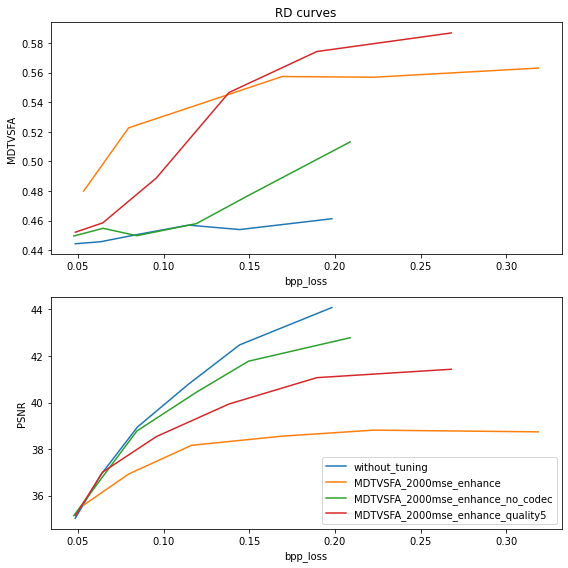

In [50]:
import matplotlib.pyplot as plt
model_names = ["models_enhancement/model_vimeo11k_without_tuning",
               "models_enhancement/model_vimeo11k_original_model.ckpt", 
                                   "models_enhancement/model_vimeo11k_MDTVSFA_2000mse_enhance.ckpt", 
                                   "models_enhancement/model_vimeo11k_MDTVSFA_2000mse_enhance_no_codec.ckpt",
                                   "models_enhancement/model_vimeo11k_MDTVSFA_2000mse_enhance_quality5.ckpt"]
test_RDcurves = [test_RDcurves[0]] + test_RDcurves[2:]
model_names = [model_names[0]] + model_names[2:]
model_names = [model_name.split("models_enhancement/model_vimeo11k_")[-1].split(".ckpt")[0] for model_name in model_names]
plt.figure(figsize = (8,8))
for (idx, j), name in zip(enumerate(test_RDcurves), model_names):
    plt.subplot(2,1,1)
    plt.title("RD curves")
    plt.ylabel("MDTVSFA")
    plt.xlabel("bpp_loss")
    plt.plot(j['bpp_loss'], -np.array(j['MDTVSFA']), label = name)
    plt.subplot(2,1,2)
    plt.plot(j['bpp_loss'], np.array(j['PSNR']), label = name)
    plt.ylabel("PSNR")
    plt.xlabel("bpp_loss")
    #bpp_gain = np.array(j['bpp_loss']) - test_RDcurves[0]['bpp_loss']
    #MDTVSFA_gain = np.array(j['MDTVSFA']) - test_RDcurves[0]['MDTVSFA']
    #PSNR_gain = np.array(j['PSNR']) - test_RDcurves[0]['PSNR']
plt.legend()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.tight_layout() 
    

In [67]:
len(train_RDcurves)

3

<ipython-input-69-5467ea42b8ad>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,1,1)
<ipython-input-69-5467ea42b8ad>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,1,2)
<ipython-input-69-5467ea42b8ad>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and re

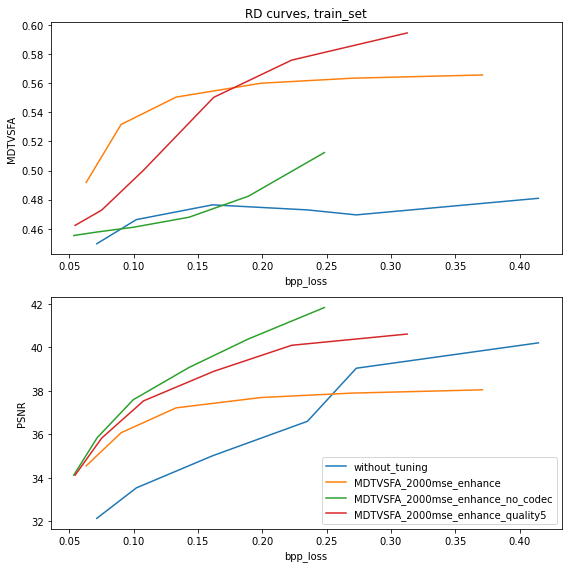

In [69]:
import matplotlib.pyplot as plt
model_names = ["models_enhancement/model_vimeo11k_without_tuning",
               "models_enhancement/model_vimeo11k_original_model.ckpt", 
                                   "models_enhancement/model_vimeo11k_MDTVSFA_2000mse_enhance.ckpt", 
                                   "models_enhancement/model_vimeo11k_MDTVSFA_2000mse_enhance_no_codec.ckpt",
                                   "models_enhancement/model_vimeo11k_MDTVSFA_2000mse_enhance_quality5.ckpt"]
train_RDcurves = [train_RDcurves[0]] + train_RDcurves[2:]
model_names = [model_names[0]] + model_names[2:]
model_names = [model_name.split("models_enhancement/model_vimeo11k_")[-1].split(".ckpt")[0] for model_name in model_names]
plt.figure(figsize = (8,8))
for (idx, j), name in zip(enumerate(train_RDcurves), model_names):
    plt.subplot(2,1,1)
    plt.title("RD curves, train_set")
    plt.ylabel("MDTVSFA")
    plt.xlabel("bpp_loss")
    plt.plot(j['bpp_loss'], -np.array(j['MDTVSFA']), label = name)
    plt.subplot(2,1,2)
    plt.plot(j['bpp_loss'], np.array(j['PSNR']), label = name)
    plt.ylabel("PSNR")
    plt.xlabel("bpp_loss")
    #bpp_gain = np.array(j['bpp_loss']) - test_RDcurves[0]['bpp_loss']
    #MDTVSFA_gain = np.array(j['MDTVSFA']) - test_RDcurves[0]['MDTVSFA']
    #PSNR_gain = np.array(j['PSNR']) - test_RDcurves[0]['PSNR']
plt.legend()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.tight_layout() 
    

In [12]:
10 * torch.log10(1. / torch.tensor(logs_plot['mse_loss']))

tensor([27.1534, 40.0123, 40.1212, 40.2428, 40.1336, 40.1630, 39.9371, 39.9142])

<ipython-input-1-547893a9ba4f>:342: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, math.ceil( (len(unique_idx)+1) / 2), cur_idx + 1, )
<ipython-input-1-547893a9ba4f>:342: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, math.ceil( (len(unique_idx)+1) / 2), cur_idx + 1, )
<ipython-input-1-547893a9ba4f>:342: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently

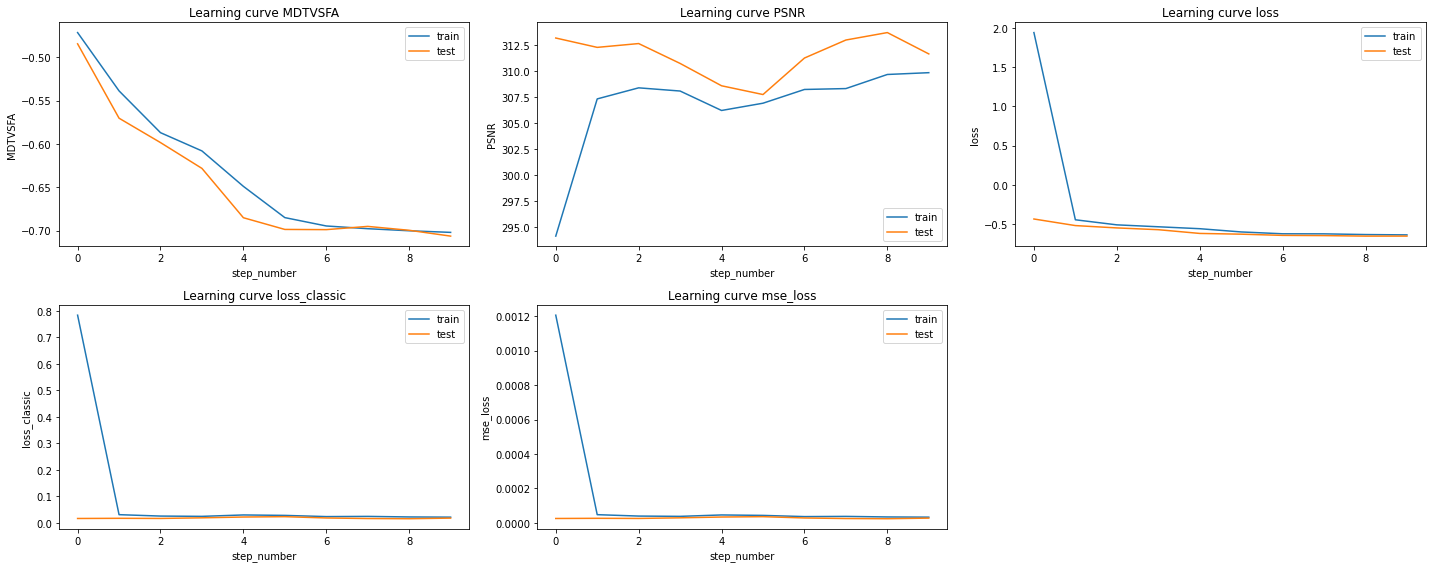

<Figure size 432x288 with 0 Axes>

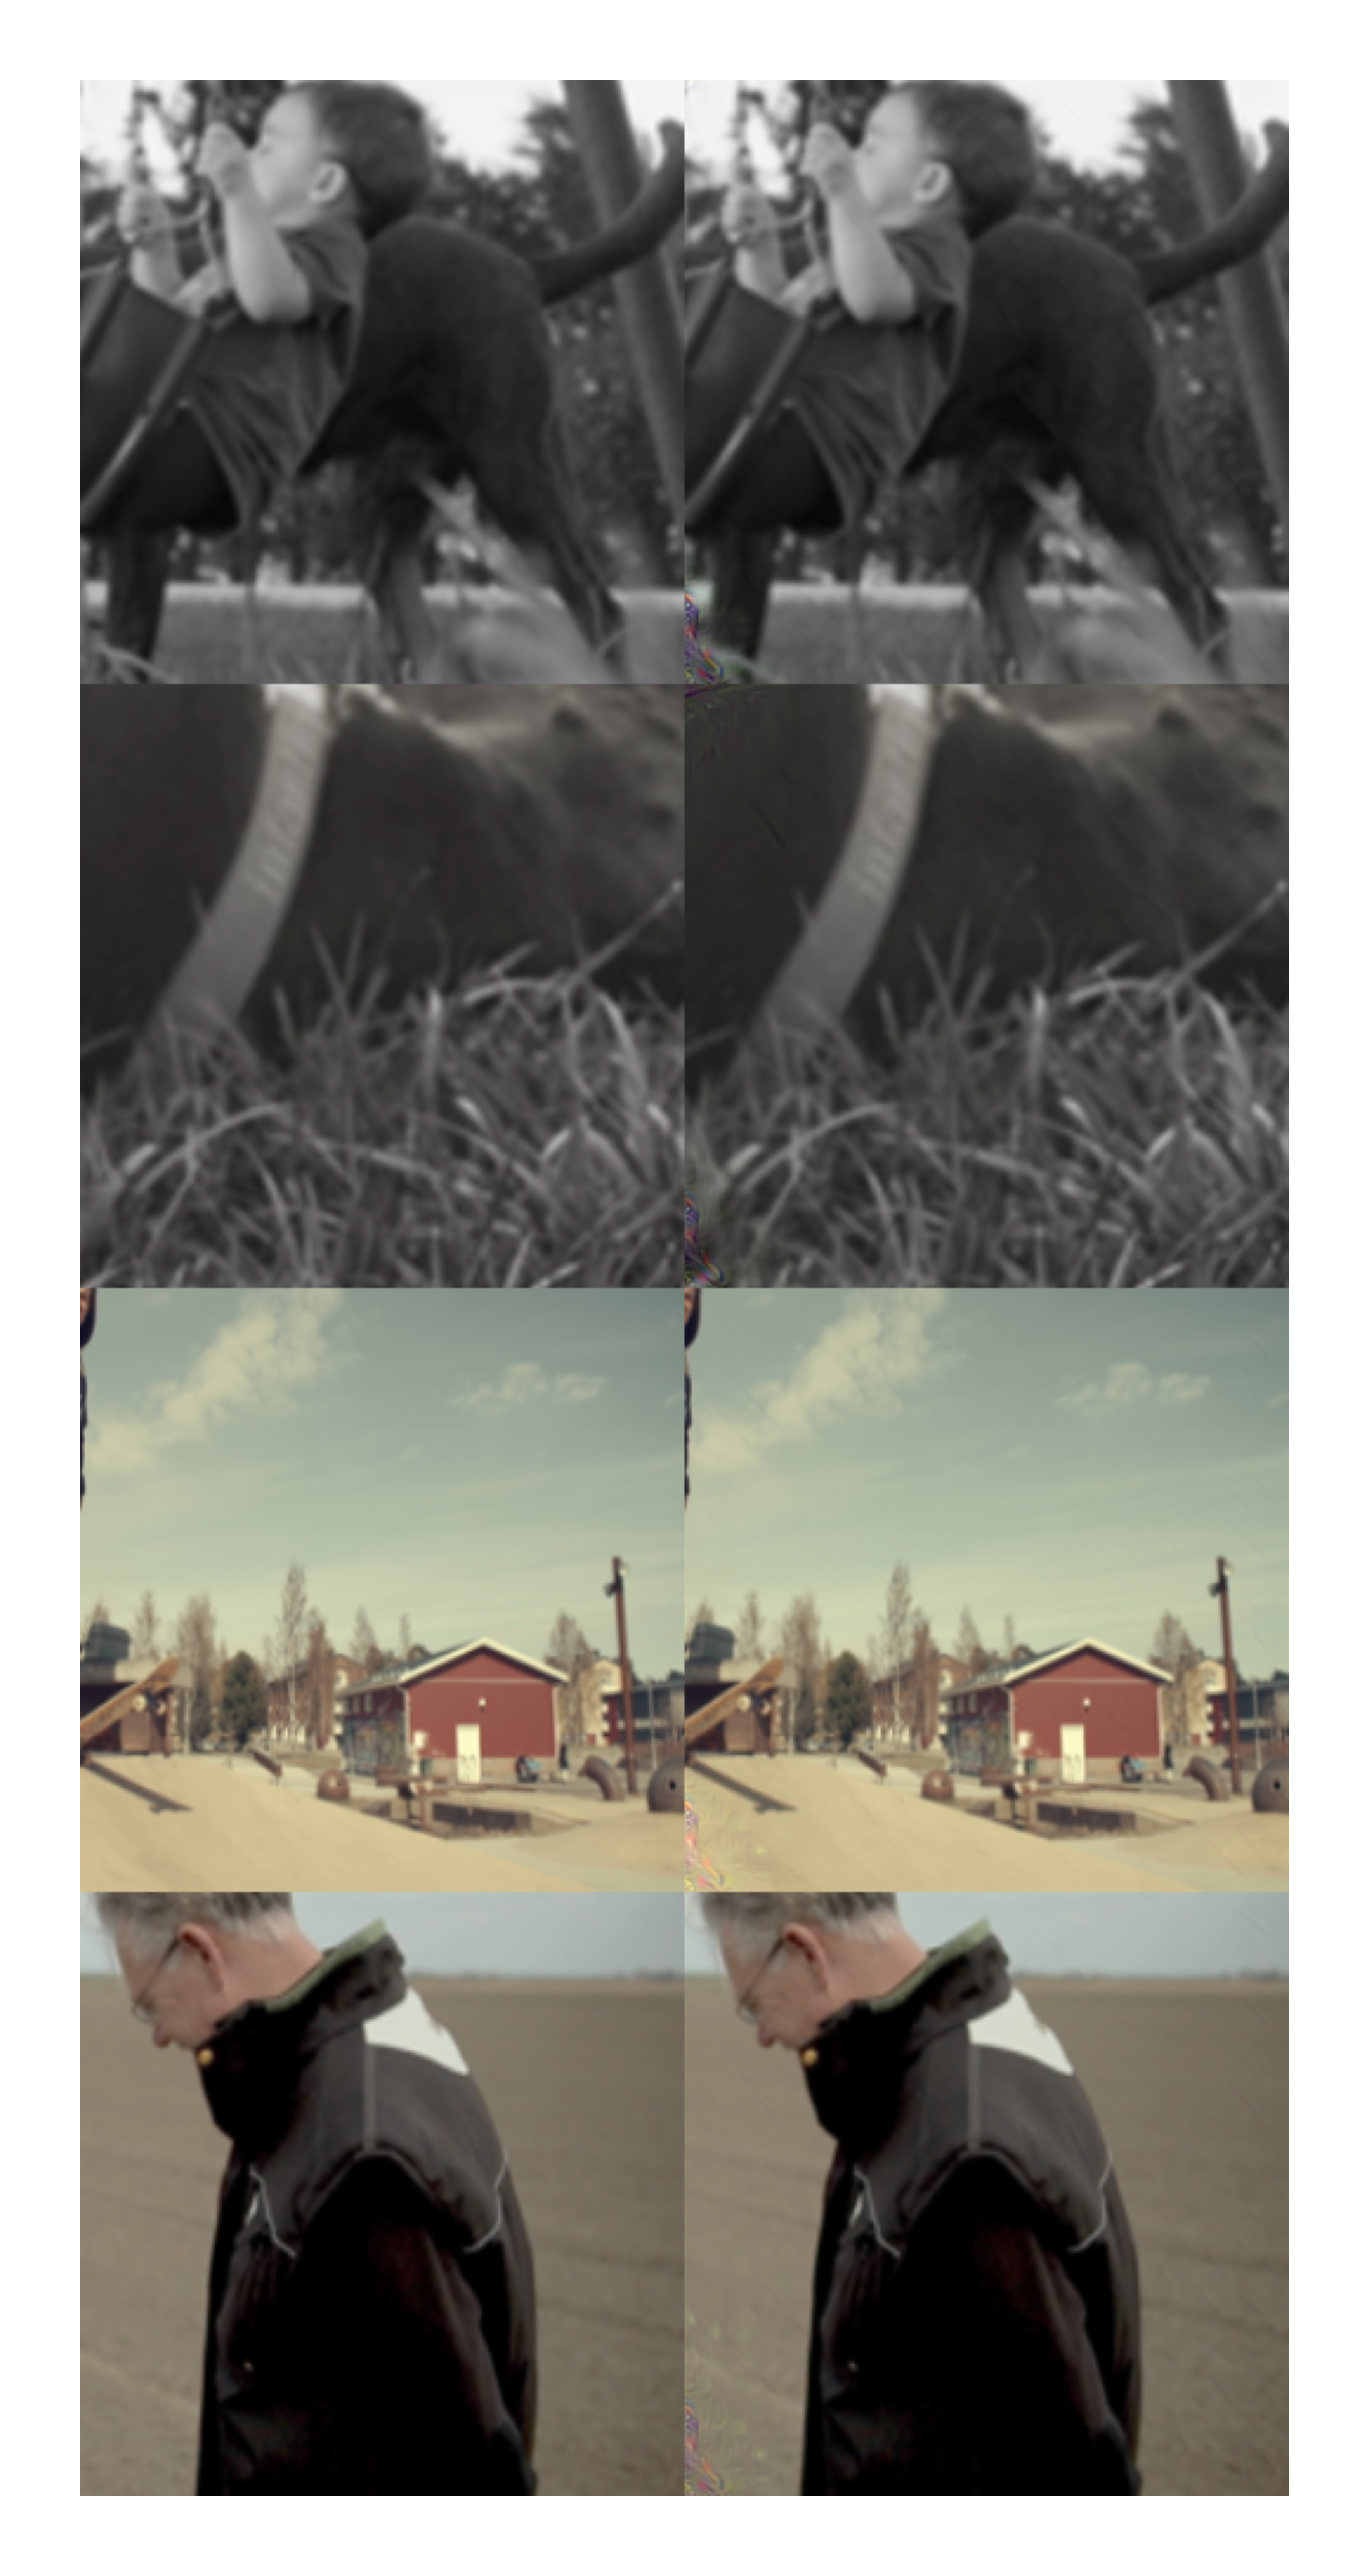

  0%|          | 0/2750 [00:00<?, ?it/s]

In [ ]:
exec(open('main.py').read())
import compressai
import math
from compressai.zoo import bmshj2018_factorized, cheng2020_attn, mbt2018,ssf2020
import torch
from PIL import Image
import torchvision.transforms
import torch
import skvideo.io
from PIL import Image
import numpy as np
from CNNfeatures import get_features
from VQAmodel import VQAModel
from argparse import ArgumentParser
import time
from PIL import Image
import torch
import numpy as np
from torch import nn
import torch.optim as optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net_enhance = None





def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = torchvision.models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out
    

net_enhance = ResNetUNet(3).to(device)
#nn codec
#EXEC

save_filename = "vimeo11k_MDTVSFA_LPIPS_DISTS_enhance_no_codec"



#net_codec = bmshj2018_factorized(quality=2, pretrained=True).train().to(device)
#mbt2018
net_codec = cheng2020_attn(quality=2, pretrained=True).train().to(device)# ssf2020 -- video
env = calc_met( model = "MDTVSFA", home_dir1=home_dir,dataset_dir=dst_dir)
#env.datagen = [frameGT for frameGT in skvideo.io.FFmpegReader(env.dataset_dir + env.dataset[0], outputdict={"-c:v" :" rawvideo","-f": "rawvideo"}).nextFrame()]
self = env
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


from piq import LPIPS as piq_LPIPS#PieAPP VSI, FSIM, NLPD, deepIQA
from piq import DISTS as piq_DISTS
import IQA_pytorch as iqa#SSIM, GMSD, LPIPSvgg, DISTS
lpips = iqa.LPIPSvgg().to(device)
dists = iqa.DISTS().to(device)

def loss_calc(X_out, Y):
    if X_out['x_hat'].device != Y.device:
        X_out['x_hat'] = X_out['x_hat'].to(device)
    dist = metr.MDTVSFA(X_out['x_hat'])
    loss = rdLoss(X_out, Y)
    loss['MDTVSFA'] = -dist
    lmbda = 1e-2
    loss["loss"] = loss['MDTVSFA'] + loss["bpp_loss"] + lmbda / 2 * loss["mse_loss"] * 255 ** 2# * loss["mse"] + loss["bpp_loss"]
    #loss["aux_loss"] = net_codec.aux_loss()
    return loss

class Video_reader_read():
    def __init__(self,name1 = dst_dir + "blue_hair_1920x1080_30.yuv.Y4M"):
        self.nameGT = name1
        
    def get_frame(self):
        self.temp_reader1 = skvideo.io.FFmpegReader(self.nameGT, outputdict={"-c:v" :" rawvideo","-f": "rawvideo"})
        self.datagenGT = [frameGT / 255. for frameGT in self.temp_reader1.nextFrame()]
        self.temp_reader1.close()
        self.datagenGT = np.array([[i[:,:,0],i[:,:,1],i[:,:,2]] for i in self.datagenGT])
        self.lst_1 = torch.tensor(self.datagenGT[0]).float() - 0.5
        return torch.stack([self.lst_1])
rd = Video_reader_read()
def pltimshow(arg):
    plt.imshow(arg.cpu().detach().numpy().swapaxes(1,3).swapaxes(1,2)[0])
class calc_met:
    def __init__(self,dataset1 = ["Run439.Y4M"], convKer1 = None, home_dir1 = "R:/", creat_dir = False, calc_SSIM_PSNR = False, calc_model_features = False, model = "vmaf_v063" , codec = '   -preset:v medium -x265-params log-level=error ',dataset_dir = "dataset/"):
        self.device = "cuda:0"
        self.model = VQAModel().to(device)
        self.model.load_state_dict(torch.load('../models/MDTVSFA.pt'))
        self.model.train()
        self.frame_batch_size = 1
        self.dataset_err = None
        self.dataset_err_torch = None
        self.dataset_np = None
        self.dataset_torch = None
        self.datagen = None
        self.features = None
        self.dataset = []
        self.crf_arr = []
        self.dataset_dir = dataset_dir
        self.calc_model_features = calc_model_features
        self.Results = []
        self.relative_score, self.mapped_score, self.aligned_score = 0,0,0
    def MDTVSFA(self, transformed_video):
        with torch.enable_grad():
            self.features = get_features(transformed_video, frame_batch_size=self.frame_batch_size, device=self.device)
            self.features = torch.unsqueeze(self.features, 0) 
            if len(self.features.shape) == 2:
                self.features = self.features.unsqueeze(0)
            input_length = self.features.shape[1] * torch.ones(1, 1, dtype=torch.long)
            self.relative_score, self.mapped_score, self.aligned_score = self.model.forward([(self.features, input_length, ['K'])])
            y_pred = self.mapped_score[0][0]#.to('cpu').detach().numpy()
        return y_pred
metr = calc_met()

def pltimshow_batch(args, filename = "vis/tmp.png"):
    plt.figure(dpi = 800)
    Ar2 = None
    for arg in args:
        Ar1 = np.concatenate([i for i in arg.cpu().detach().numpy().swapaxes(1,3).swapaxes(1,2)], 0)
        if Ar2 is None:
            Ar2 = Ar1
        else:
            Ar2 = np.concatenate([Ar2,Ar1],1)
    plt.imshow(Ar2)
    plt.axis('off')
    plt.savefig(filename, bbox_inches='tight')
#X_orig = cheng2020_attn(quality=2, pretrained=True)(X.cpu())
class RateDistortionLoss(nn.Module):
    """Custom rate distortion loss with a Lagrangian parameter."""
    def __init__(self, lmbda=1e-2):
        super().__init__()
        self.mse = nn.MSELoss()
        self.lmbda = lmbda

    def forward(self, output, target):
        N, _, H, W = target.size()
        out = {}
        num_pixels = N * H * W
        out["mse_loss"] = self.mse(output, target)
        out["PSNR"] = 10 * torch.log10(1**2 / out["mse_loss"])
        out["loss_classic"] = self.lmbda * 255 ** 2 * out["mse_loss"] 
        return out
rdLoss = RateDistortionLoss()
from torch.utils.data import Dataset, IterableDataset
dst_dir_vimeo = 'P:/vimeo_triplet/sequences/'
from torchvision.io import read_image
from torch.utils.data import DataLoader
import os
import torchvision
def dir_of_dirs(paths):
    A = []
    for j in paths:
        for i in os.listdir(j):
            A.append(os.path.join(j, i))
    return A

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None,train = True, datalen = 128):
        super(CustomImageDataset).__init__()
        self.datalen = datalen
        self.train = train
        self.image = 0
        self.label = 0
        self.img_names = dir_of_dirs(dir_of_dirs(dir_of_dirs([dst_dir_vimeo])))
        self.img_dir = img_dir
    def __len__(self):
        return self.datalen#9600#len(self.img_names)
    def __getitem__(self, idx):
        if not self.train:
            idx = len(self.img_names) - idx - 1
        img_path = self.img_names[idx]
        image = read_image(img_path)
        if len(image.shape) == 2 or image.shape[0] == 1:
            image = torch.cat([image for i in range(3)])
        self.image = image
        return torchvision.transforms.RandomResizedCrop((256,256))(self.image) / 255.
    
#dataset = CustomImageDataset(dst_dir_vimeo)#219k
#dataset_train = iter(DataLoader(dataset, batch_size= 16, shuffle = True))#13k

#dataset_train, dataset_test = torch.utils.data.random_split( dataset,[int(len(dataset)*0.9),len(dataset)-int(len(dataset)*0.9)])
dataset_train = CustomImageDataset(dst_dir_vimeo,train= True, datalen = 11000)
dataset_test = CustomImageDataset(dst_dir_vimeo,train= False, datalen = 400)
dataset_train = DataLoader(dataset_train, batch_size= 4, shuffle = True)#8
dataset_test = DataLoader(dataset_test, batch_size= 4, shuffle = True)#8
mse_loss = nn.MSELoss()
#opt_target = [i for i in net_codec.parameters()]
opt_target = [p for n,p in net_codec.named_parameters()]
#optimizer = optim.Adam(opt_target, lr = 0.001)
dr_name = "v_mse"
AV_log = []
curve_mse = []
plot_data = []
plot_data_mse = []
from IPython.display import clear_output

parameters = set(p for n, p in net_enhance.named_parameters()) # set(p for n, p in net_codec.named_parameters() if not n.endswith(".quantiles"))
aux_parameters = set(p for n, p in net_codec.named_parameters() if n.endswith(".quantiles"))
aux_loss = net_codec.entropy_bottleneck.loss()
optimizer = optim.Adam(parameters, lr=1e-4)
aux_optimizer = optim.Adam(aux_parameters, lr=1e-3)
save_netcodec = False

save_result = True
X_sample = torch.load("sample_data/X.ckpt")

n = 30
rd = Video_reader_read()
logs_plot_cur = {}
logs_plot = {}
max_epoch = 12
skip_0epoch = True
for epoch in tqdm(range(max_epoch)):
    if skip_0epoch and epoch == 0:
        continue
    idx_video = 0
    logs_plot_cur = {}
    for to_train in [True, False]:
        tqdm_dataset = tqdm(dataset_train if to_train else dataset_test)
        for frame in tqdm_dataset:    
            idx_video += 1
            X = frame
            X = torchvision.transforms.RandomResizedCrop((256,256))(X)
            X = X.detach().to(device)
            Y = X.detach().clone().to(device)
            optimizer.zero_grad()
            aux_optimizer.zero_grad()
            X_enhance = net_enhance(X)
            X_out = X_enhance##############################No codec
            loss = rdLoss(X_out, Y)
            lmbda = 1e-2
            #with torch.no_grad():
            loss['MDTVSFA'] = -metr.MDTVSFA(X_out)
            #loss["LPIPS"] = lpips(X_out['x_hat'], X)
            #loss["DISTS"] = dists(X_out['x_hat'], X)
            loss["loss"] =  loss['MDTVSFA']  + 2000*loss['mse_loss']#loss["DISTS"] + loss["bpp_loss"] + loss["LPIPS"] + loss['MDTVSFA'] 
            
            if epoch != 0 and to_train:
                loss["loss"].backward()
                optimizer.step()
            #loss["aux_loss"] = net_codec.aux_loss()
            #if epoch != 0 and to_train:
                #loss["aux_loss"].backward()
                #aux_optimizer.step()
                
            torch.nn.utils.clip_grad_norm_(opt_target, 1)
            #optimizer.step()
            
            for j in list(loss.keys()):
                j_converted = j + ("_test" if not to_train else "")
                if not j_converted in logs_plot_cur:
                    logs_plot_cur[j_converted] = []
                logs_plot_cur[j_converted].append(loss[j].data.to("cpu").numpy())
            
            X.data.clamp_(min=0,max=1)
            X_out.data.clamp_(min=0,max=1)
            torch.nn.utils.clip_grad_norm_(opt_target, 1)
            
    if not to_train:
        for j in list(logs_plot_cur.keys()):
            if not j in logs_plot:
                logs_plot[j] = []
            logs_plot[j].append(np.mean(logs_plot_cur[j]))
    if 1:
        clear_output()
        fig = plt.figure(figsize=(20,8))
        unique_names = list(np.unique(list(map(lambda x : x.split("_test")[0], list(logs_plot.keys())))))
        unique_idx = {i: j for i, j in zip(unique_names, range(len(unique_names)))}
        for plot_idx, plot_i in enumerate(list(logs_plot.keys())):
            short_name = plot_i.split("_test")[0]
            cur_idx = unique_idx[short_name]    
            plt.subplot(2, math.ceil( (len(unique_idx)+1) / 2), cur_idx + 1, )
            plt.xlabel("step_number")
            plt.title("Learning curve " + short_name)
            plt.ylabel(short_name)
            plt.plot(np.arange(len(logs_plot[plot_i])), logs_plot[plot_i], label = ("train" if short_name == plot_i else "test"))    
            plt.legend()
            plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
            plt.tight_layout() 
        if save_result == True:
            fig.savefig("vis/lerningcurve" + save_filename + ".png")
            if save_netcodec == True:
                torch.save(net_codec.state_dict(), "models/model_" +save_filename + ".ckpt") 
            if net_enhance != None:
                torch.save(net_enhance.state_dict(), "models_enhancement/model_" +save_filename + ".ckpt") 
            import pickle
            with open('models/plots'+ save_filename + '.pkl', 'wb') as f:
                pickle.dump(logs_plot, f)
    
        tqdm_dataset.refresh()
        plt.show()
        plt.figure(25)
        #X.data = X_sample.data
        #X_out = net_codec.forward(X)
        pltimshow_batch([X, X_out], filename = "vis/pics_" + save_filename + ".png")
        plt.pause(0.005)